In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-data/Utopia Sublime Bank Group.csv
/kaggle/input/stock-data/Pacific Bank of Utopia.csv
/kaggle/input/stock-data/Utopia Power Solutions.csv
/kaggle/input/stock-data/Utopia Petroleums.csv
/kaggle/input/stock-data/Utopian Bank.csv
/kaggle/input/stock-data/Union Bank of Utopia.csv
/kaggle/input/stock-data/Utopia Oil and Gas.csv
/kaggle/input/stock-data/Utopian Financial Services.csv
/kaggle/input/stock-data/Utopia General Power.csv
/kaggle/input/stock-data/Northern Bank of Utopia.csv
/kaggle/input/stock-data/United Utopia Energy Corporation.csv
/kaggle/input/stock-data/Natural Gas Corp of Utopia.csv
/kaggle/input/stock-data/Utopia Energy.csv


In [2]:
#load csv's for easier access
final_df=pd.DataFrame()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        df=pd.read_csv(os.path.join(dirname, filename))
        df['company_name']=filename.replace('.csv','')
        frames=[final_df, df]
        final_df= pd.concat(frames)

final_df.head()

,Date,Open,High,Low,Close,company_name
0,2043-01-01,603.23,655.12,609.57,575.76,Utopia Sublime Bank Group
1,2043-01-02,765.08,565.14,590.23,656.34,Utopia Sublime Bank Group
2,2043-01-03,598.19,559.82,633.41,639.92,Utopia Sublime Bank Group
3,2043-01-06,641.44,634.57,638.60,609.34,Utopia Sublime Bank Group
4,2043-01-07,626.65,660.70,530.87,712.53,Utopia Sublime Bank Group


In [3]:
final_df['company_name'].unique()
company_list= final_df['company_name'].unique()

In [4]:
#as we have to predict closing price, lets remove close price missing values from final_df
final_df = final_df[final_df['Close'].notna()]

In [5]:
USBG= final_df[final_df['company_name']=='Utopia Sublime Bank Group']
PBU= final_df[final_df['company_name']=='Pacific Bank of Utopia']
UPU= final_df[final_df['company_name']=='Utopia Power Solutions']
UP= final_df[final_df['company_name']=='Utopia Petroleums']
UB= final_df[final_df['company_name']=='Utopian Bank']
UBU= final_df[final_df['company_name']=='Union Bank of Utopia']
UOG= final_df[final_df['company_name']=='Utopia Oil and Gas']
UFS= final_df[final_df['company_name']=='Utopian Financial Services']
UGP= final_df[final_df['company_name']=='Utopia General Power']
NBU= final_df[final_df['company_name']=='Northern Bank of Utopia']
UUEC= final_df[final_df['company_name']=='United Utopia Energy Corporation']
NGCU= final_df[final_df['company_name']=='Natural Gas Corp of Utopia']
UE= final_df[final_df['company_name']=='Utopia Energy']

In [6]:
print(USBG.shape, PBU.shape, UPU.shape, UP.shape, UB.shape, UBU.shape, UOG.shape, UFS.shape, UGP.shape, NBU.shape, UUEC.shape, NGCU.shape, UE.shape)

(3991, 6) (3990, 6) (4004, 6) (3976, 6) (3983, 6) (3533, 6) (3980, 6) (3994, 6) (3995, 6) (2814, 6) (3986, 6) (4005, 6) (3999, 6)


In [7]:
# Summary Stats of utopia sublime bank group
USBG= final_df[final_df['company_name']=='Utopia Sublime Bank Group']
USBG.describe()

,Open,High,Low,Close
count,3927.000000,3911.000000,3908.000000,3991.000000
mean,888.936198,891.738225,883.967126,886.133528
std,292.193824,231.665695,284.359660,252.296019
min,456.930000,502.280000,521.530000,481.020000
25%,806.250000,811.075000,800.877500,810.185000
50%,889.870000,895.030000,883.465000,886.940000
75%,958.135000,965.695000,950.862500,958.425000
max,8946.658259,8177.318941,8841.342376,8678.006576


In [8]:
USBG.head()

,Date,Open,High,Low,Close,company_name
0,2043-01-01,603.23,655.12,609.57,575.76,Utopia Sublime Bank Group
1,2043-01-02,765.08,565.14,590.23,656.34,Utopia Sublime Bank Group
2,2043-01-03,598.19,559.82,633.41,639.92,Utopia Sublime Bank Group
3,2043-01-06,641.44,634.57,638.60,609.34,Utopia Sublime Bank Group
4,2043-01-07,626.65,660.70,530.87,712.53,Utopia Sublime Bank Group


In [9]:
# General info
USBG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3991 entries, 0 to 4073
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3991 non-null   object 
 1   Open          3927 non-null   float64
 2   High          3911 non-null   float64
 3   Low           3908 non-null   float64
 4   Close         3991 non-null   float64
 5   company_name  3991 non-null   object 
dtypes: float64(4), object(2)
memory usage: 218.3+ KB


In [10]:
#check for missing values
USBG.isnull().sum()

Date             0
Open            64
High            80
Low             83
Close            0
company_name     0
dtype: int64

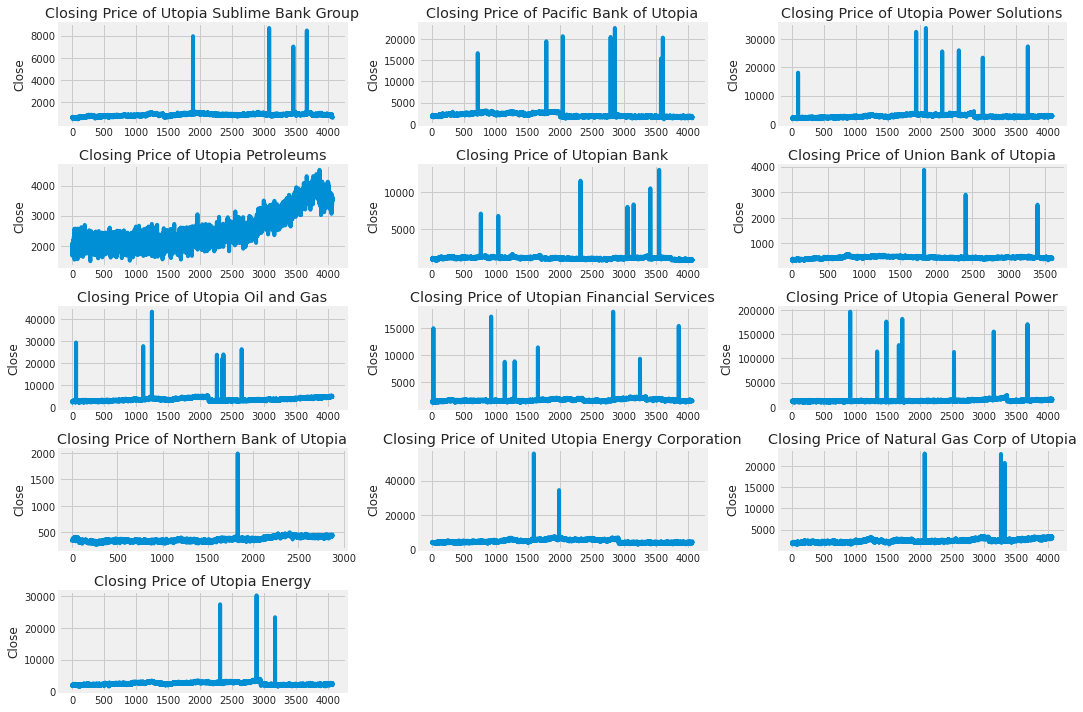

In [11]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
#     print(i, company)
    plt.subplot(5, 3, i)
    company_df= final_df[final_df['company_name']==company]
    company_df['Close'].plot()
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company_list[i - 1]}")
    
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

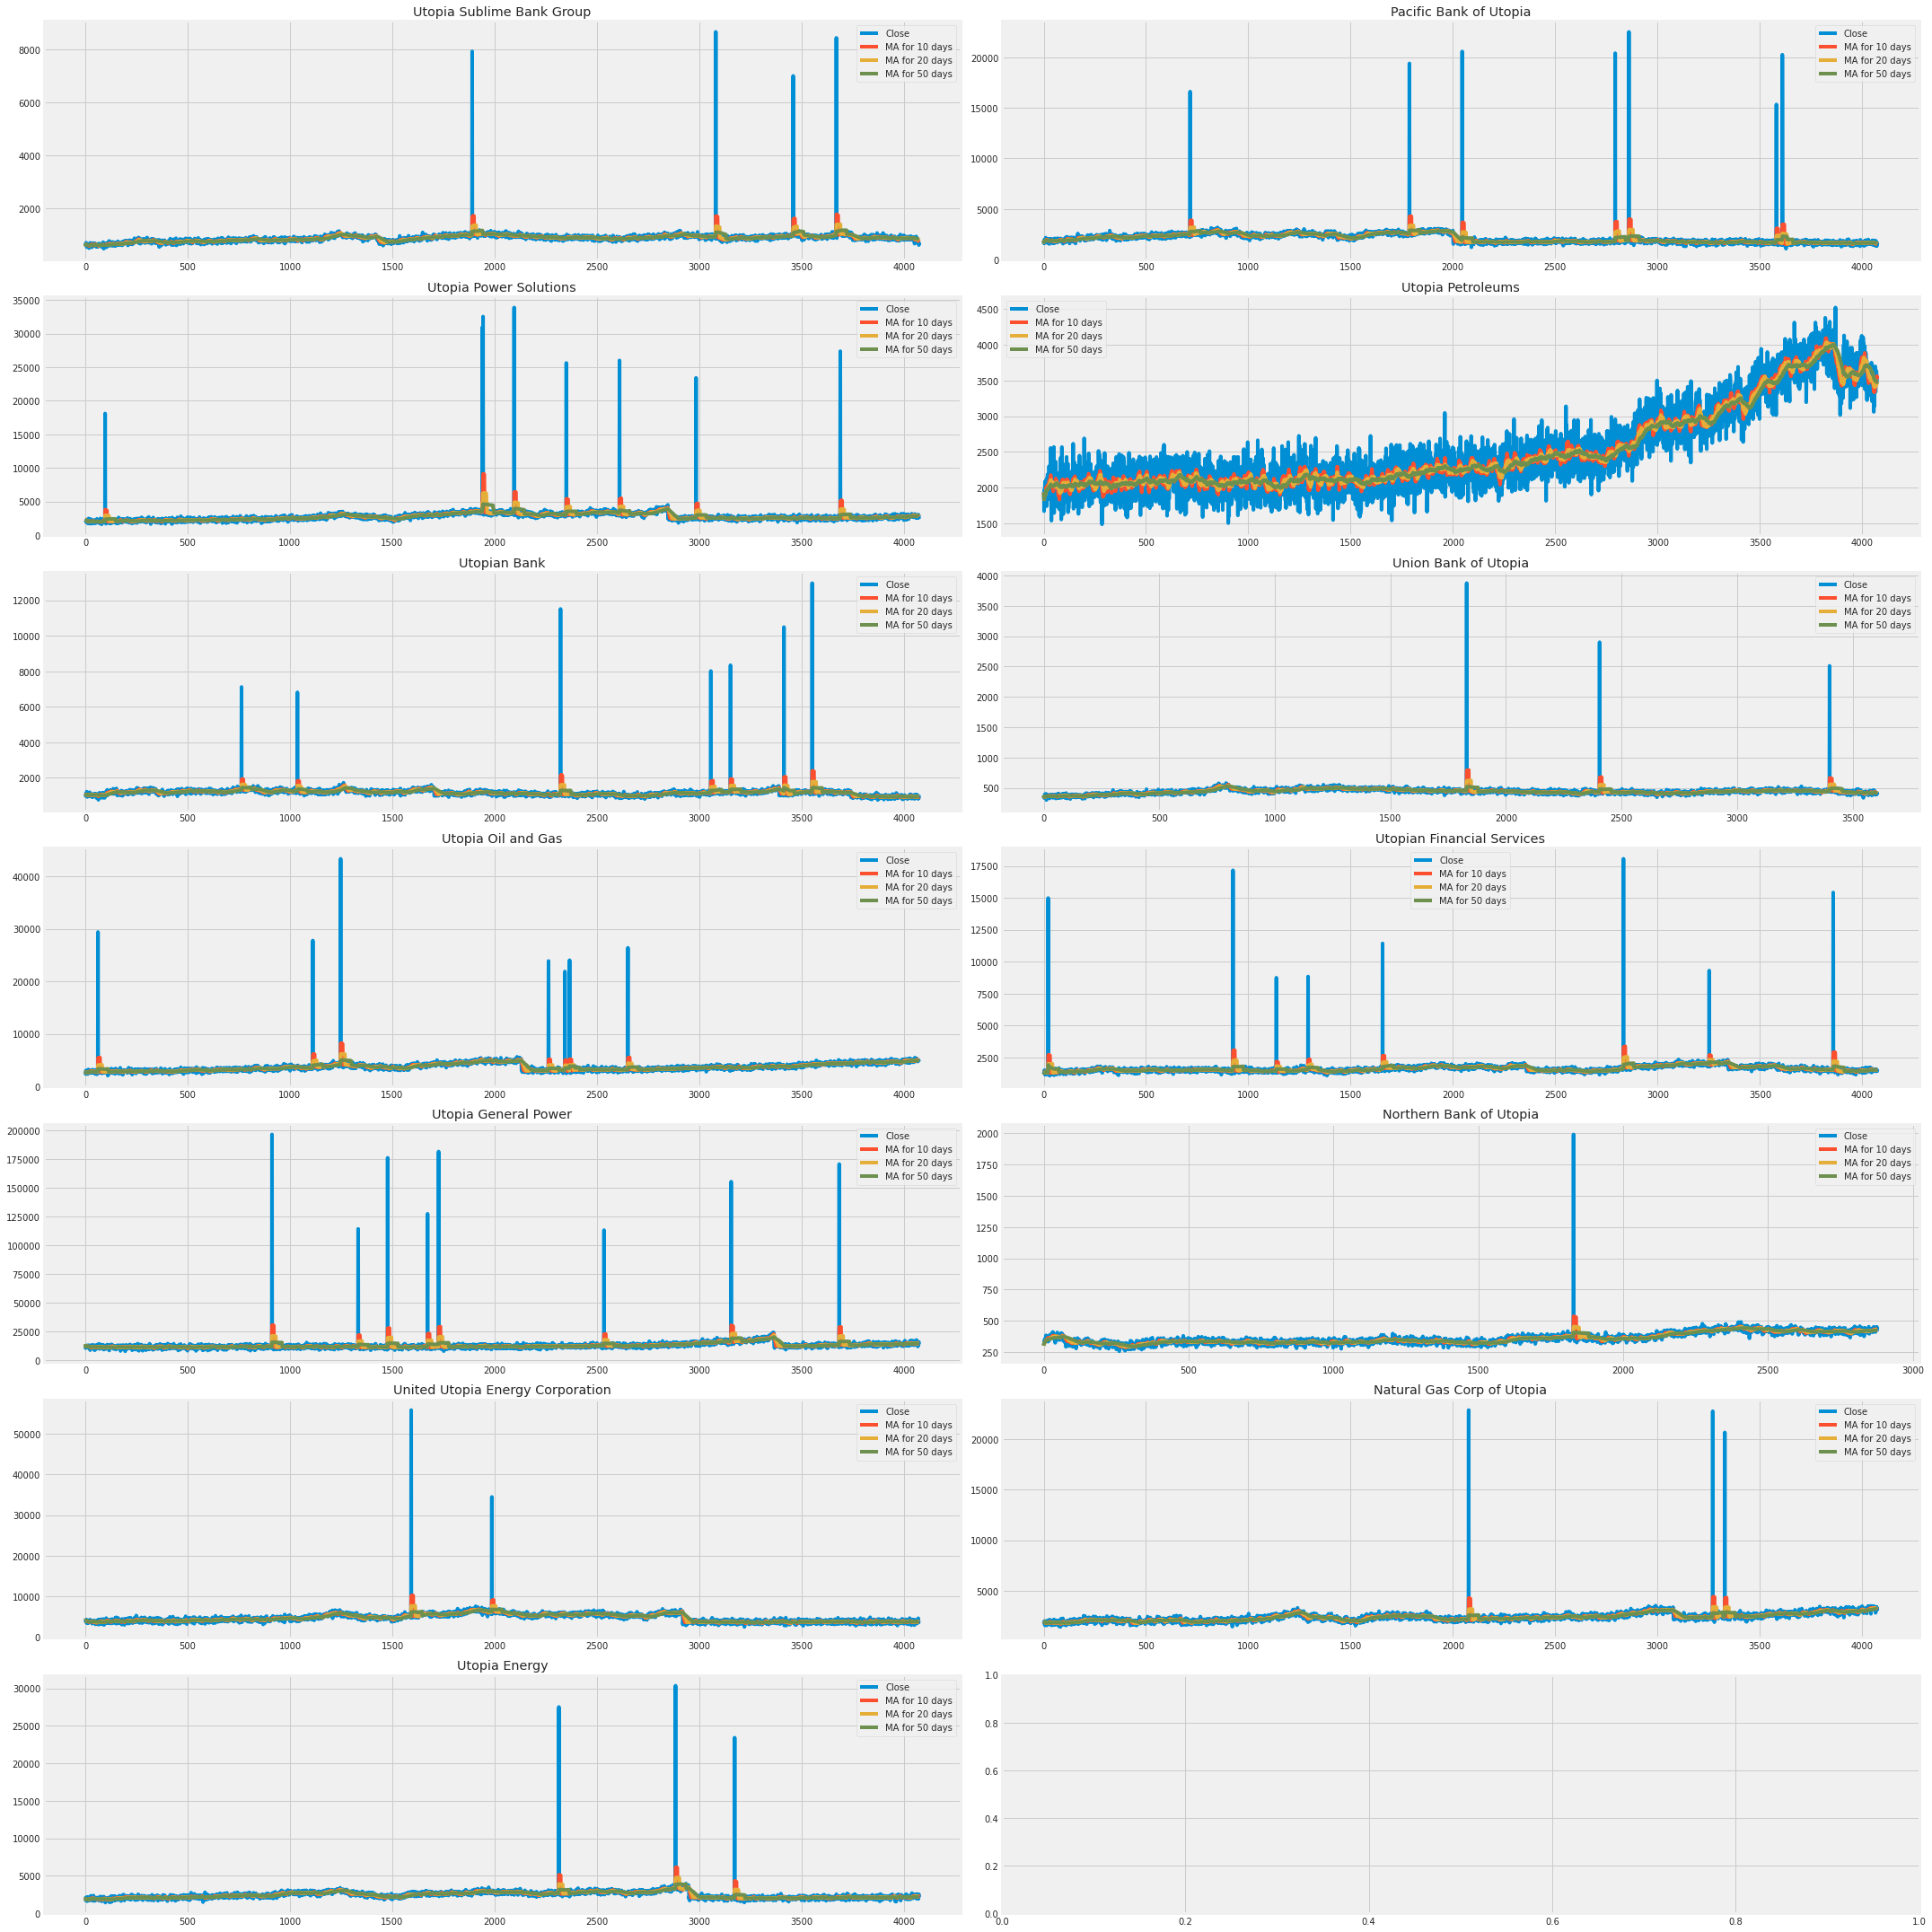

In [12]:
#Moving avg
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    USBG[column_name] = USBG['Close'].rolling(window=ma, min_periods=1).mean()
    PBU[column_name] = PBU['Close'].rolling(window=ma, min_periods=1).mean()
    UPU[column_name] = UPU['Close'].rolling(window=ma, min_periods=1).mean()
    UP[column_name] = UP['Close'].rolling(window=ma, min_periods=1).mean()
    UB[column_name] = UB['Close'].rolling(window=ma, min_periods=1).mean()
    UBU[column_name] = UBU['Close'].rolling(window=ma, min_periods=1).mean()
    UOG[column_name] = UOG['Close'].rolling(window=ma, min_periods=1).mean()
    UFS[column_name] = UFS['Close'].rolling(window=ma, min_periods=1).mean()
    UGP[column_name] = UGP['Close'].rolling(window=ma, min_periods=1).mean()
    NBU[column_name] = NBU['Close'].rolling(window=ma, min_periods=1).mean()
    UUEC[column_name] = UUEC['Close'].rolling(window=ma, min_periods=1).mean()
    NGCU[column_name] = NGCU['Close'].rolling(window=ma, min_periods=1).mean()
    UE[column_name] = UE['Close'].rolling(window=ma, min_periods=1).mean()      
    
fig, axes = plt.subplots(nrows=7, ncols=2)
fig.set_figheight(30)
fig.set_figwidth(30)


USBG[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('Utopia Sublime Bank Group')

PBU[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('Pacific Bank of Utopia')

UPU[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('Utopia Power Solutions')

UP[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('Utopia Petroleums')

UB[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[2,0])
axes[2,0].set_title('Utopian Bank')

UBU[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[2,1])
axes[2,1].set_title('Union Bank of Utopia')

UOG[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[3,0])
axes[3,0].set_title('Utopia Oil and Gas')

UFS[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[3,1])
axes[3,1].set_title('Utopian Financial Services')

UGP[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[4,0])
axes[4,0].set_title('Utopia General Power')

NBU[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[4,1])
axes[4,1].set_title('Northern Bank of Utopia')

UUEC[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[5,0])
axes[5,0].set_title('United Utopia Energy Corporation')

NGCU[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[5,1])
axes[5,1].set_title('Natural Gas Corp of Utopia')

UE[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[6,0])
axes[6,0].set_title('Utopia Energy')


fig.tight_layout()

In [13]:
final_df.head()

,Date,Open,High,Low,Close,company_name
0,2043-01-01,603.23,655.12,609.57,575.76,Utopia Sublime Bank Group
1,2043-01-02,765.08,565.14,590.23,656.34,Utopia Sublime Bank Group
2,2043-01-03,598.19,559.82,633.41,639.92,Utopia Sublime Bank Group
3,2043-01-06,641.44,634.57,638.60,609.34,Utopia Sublime Bank Group
4,2043-01-07,626.65,660.70,530.87,712.53,Utopia Sublime Bank Group


In [14]:
def generate_train_test(COMPANY):
    # Create a new dataframe with only the 'Close column 
    dataframe = df.copy()
    part_data = (final_df.loc[final_df.company_name == company, :])
    data= part_data.filter(['Close'])
    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))


    # Scale the data
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    # Create the training data set 
    # Create the scaled training data set
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(100, len(train_data)):
        x_train.append(train_data[i-100:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print(x_train)
            print(y_train)
            print()

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return dataset,training_data_len, scaler, scaled_data, x_train, y_train

In [15]:
def LSTM_model(x_train):
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', 
                  loss='mean_squared_error')
    
    return model

In [16]:
def generate_test_set(dataset, scaler, scaled_data, training_data_len):
    # test model accuracy on existing data
    # Create the testing data set
    test_data = scaled_data[training_data_len - 100: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(100, len(test_data)):
        x_test.append(test_data[i-100:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    return test_data, x_test, y_test


def predict_test_set(x_test, y_test, model):

    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print('rmse', rmse)
    return predictions

In [17]:
def visualize_results(company_df, training_data_len, predictions):
    # Plot the data
    train = company_df[:training_data_len]
    valid = company_df[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [18]:
company_list

array(['Utopia Sublime Bank Group', 'Pacific Bank of Utopia',
       'Utopia Power Solutions', 'Utopia Petroleums', 'Utopian Bank',
       'Union Bank of Utopia', 'Utopia Oil and Gas',
       'Utopian Financial Services', 'Utopia General Power',
       'Northern Bank of Utopia', 'United Utopia Energy Corporation',
       'Natural Gas Corp of Utopia', 'Utopia Energy'], dtype=object)

******************************************************************************************
Company name Utopia Sublime Bank Group
******************************************************************************************


2022-12-29 13:15:18.607496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 13:15:18.608615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 13:15:18.867286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 13:15:18.868190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 13:15:18.869051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

2022-12-29 13:15:24.984530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-29 13:15:30.454972: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


58/58 [==============================] - 11s 40ms/step - loss: 0.0011 - val_loss: 768139.5000
Epoch 2/10
58/58 [==============================] - 1s 15ms/step - loss: 9.2098e-04 - val_loss: 768129.6875
Epoch 3/10
58/58 [==============================] - 1s 15ms/step - loss: 9.0326e-04 - val_loss: 768119.0000
Epoch 4/10
58/58 [==============================] - 1s 16ms/step - loss: 9.0277e-04 - val_loss: 768122.5625
Epoch 5/10
58/58 [==============================] - 1s 15ms/step - loss: 9.1210e-04 - val_loss: 768137.0625
Epoch 6/10
58/58 [==============================] - 1s 15ms/step - loss: 9.1449e-04 - val_loss: 768130.0000
Epoch 7/10
58/58 [==============================] - 1s 15ms/step - loss: 8.9789e-04 - val_loss: 768120.9375
Epoch 8/10
58/58 [==============================] - 1s 16ms/step - loss: 9.1191e-04 - val_loss: 768134.8125
Epoch 9/10
58/58 [==============================] - 1s 16ms/step - loss: 8.9105e-04 - val_loss: 768130.0625
Epoch 10/10
58/58 [=======================

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


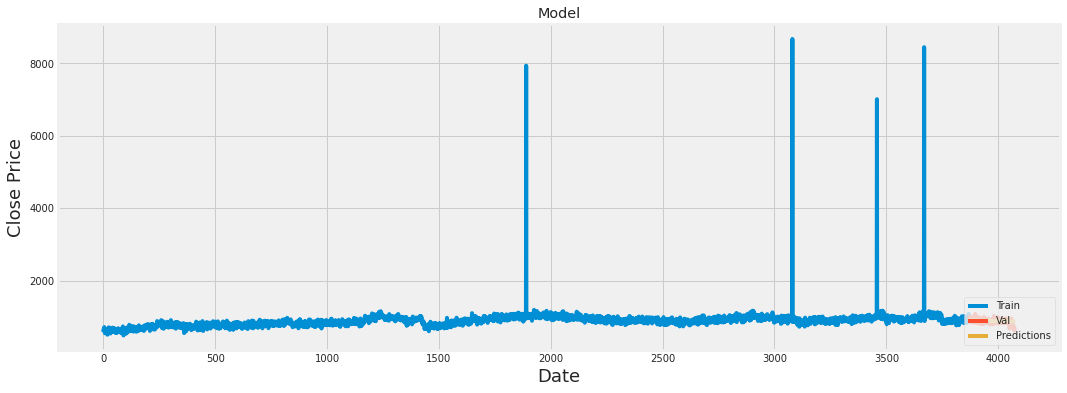

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Pacific Bank of Utopia
******************************************************************************************
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


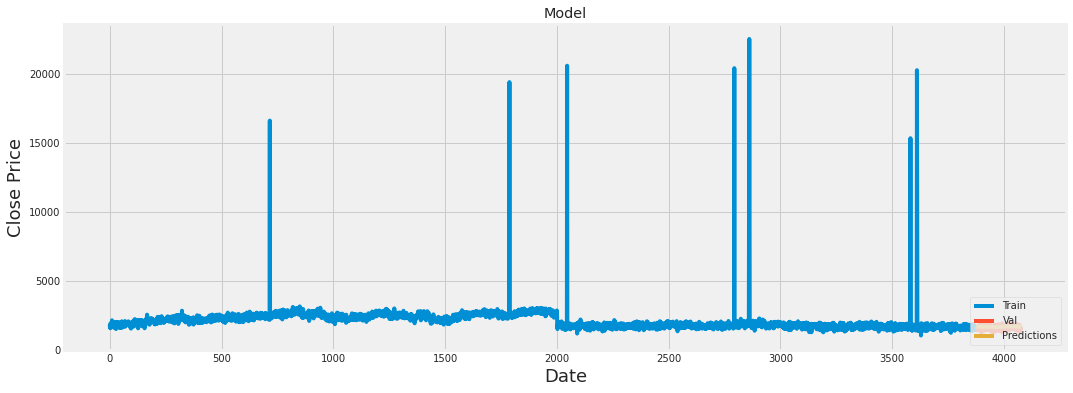

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Utopia Power Solutions
******************************************************************************************
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


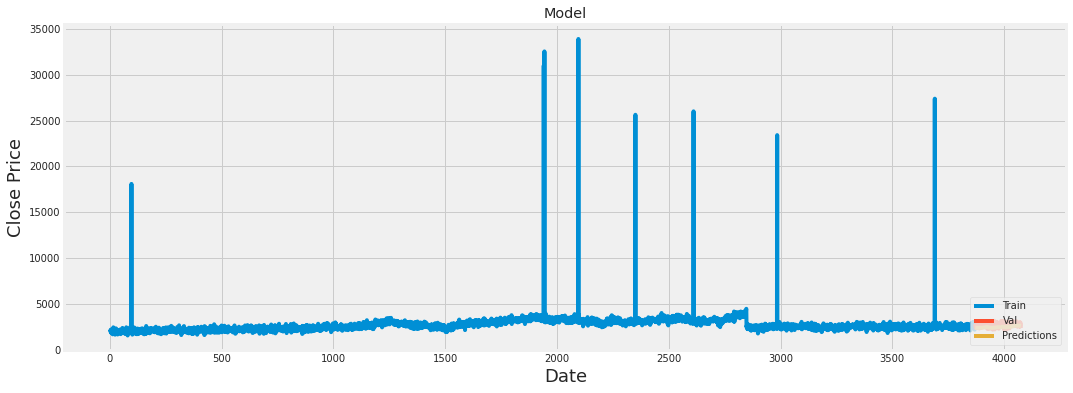

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Utopia Petroleums
******************************************************************************************
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


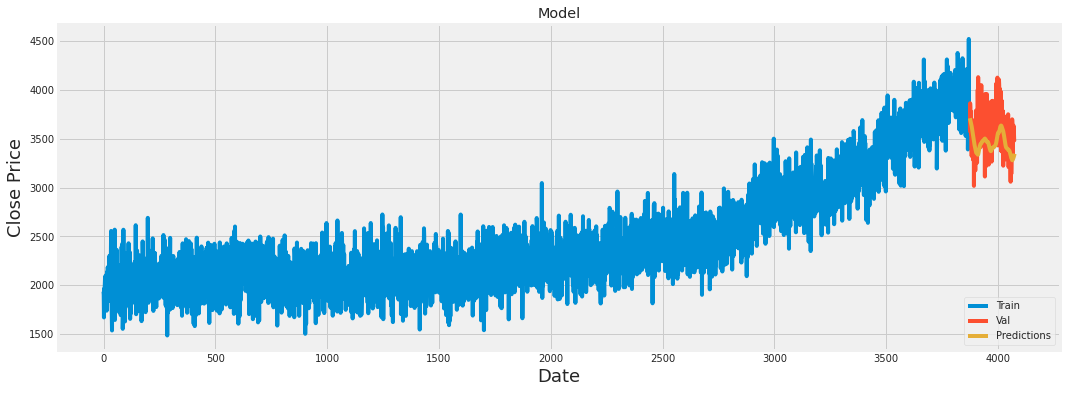

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Utopian Bank
******************************************************************************************
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


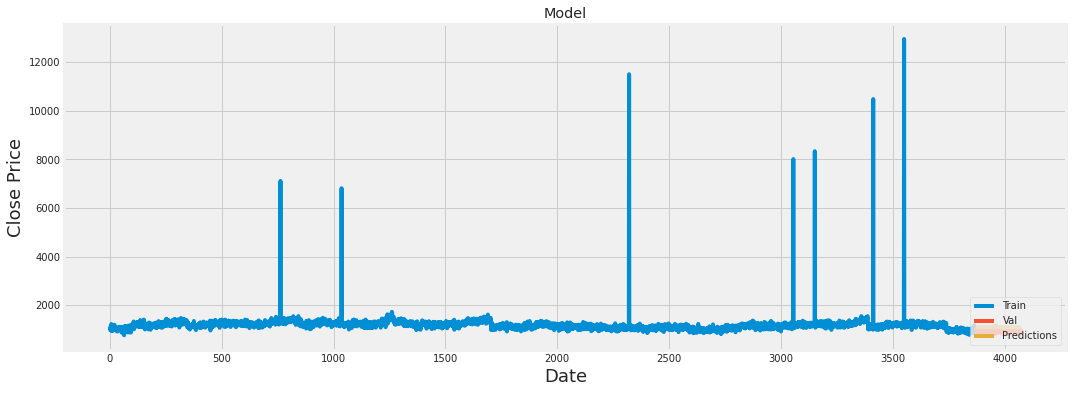

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Union Bank of Utopia
******************************************************************************************
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                202

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


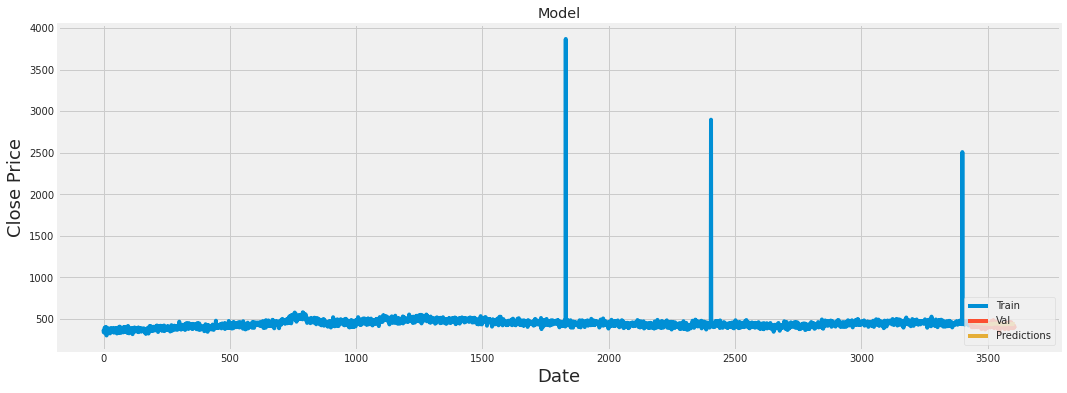

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Utopia Oil and Gas
******************************************************************************************
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


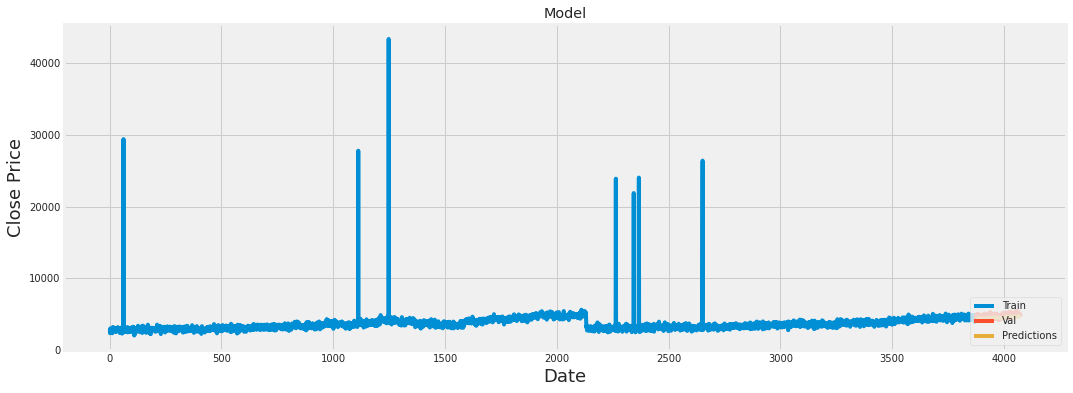

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Utopian Financial Services
******************************************************************************************
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)             

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


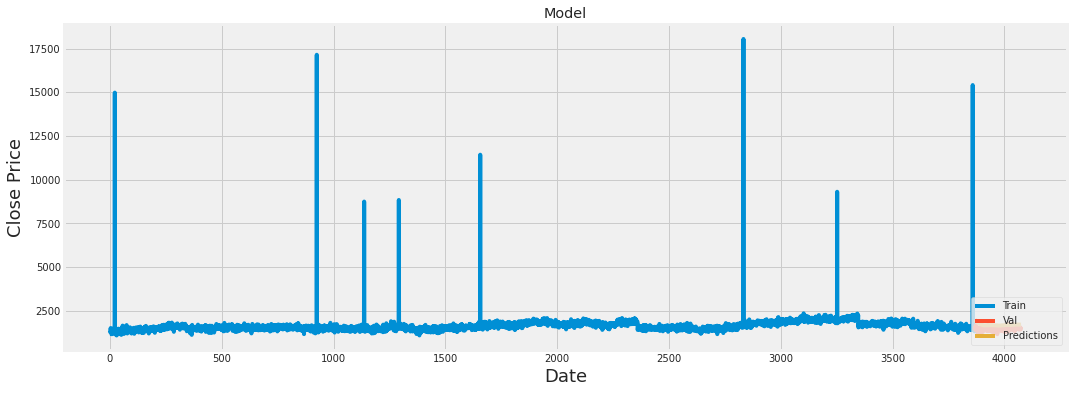

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Utopia General Power
******************************************************************************************
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                202

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


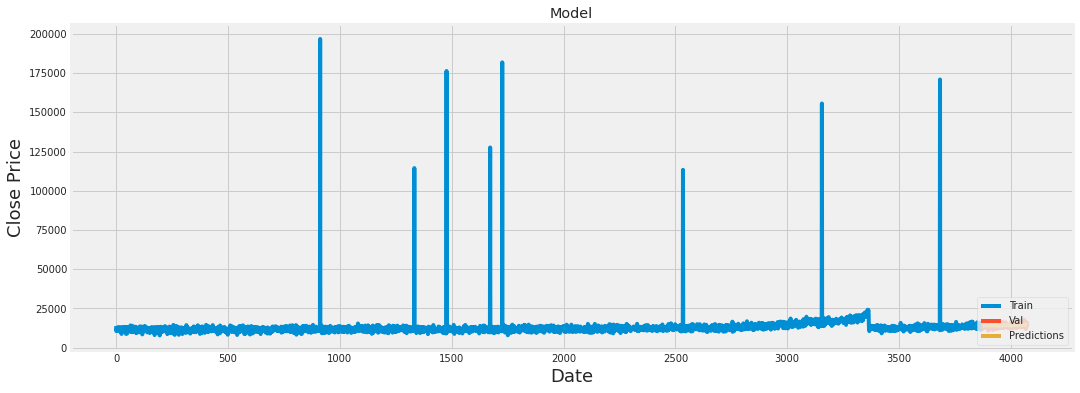

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Northern Bank of Utopia
******************************************************************************************
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_27 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 50)                

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


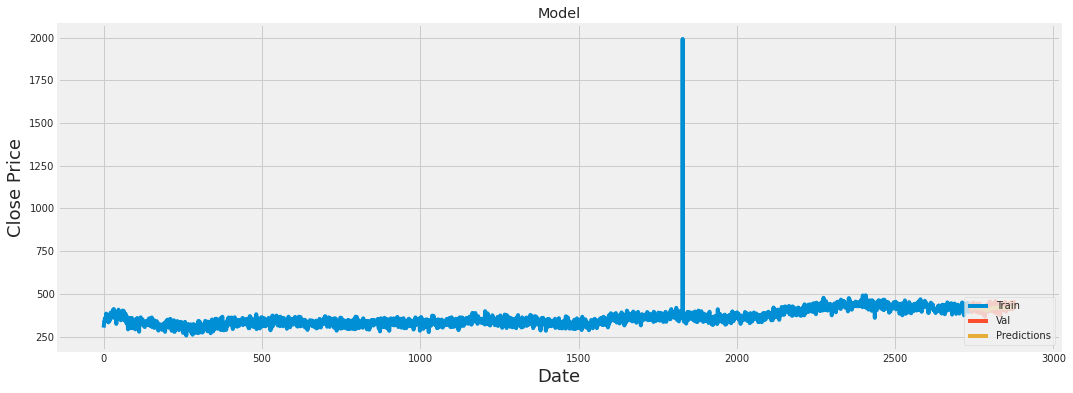

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name United Utopia Energy Corporation
******************************************************************************************
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_30 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 50)      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


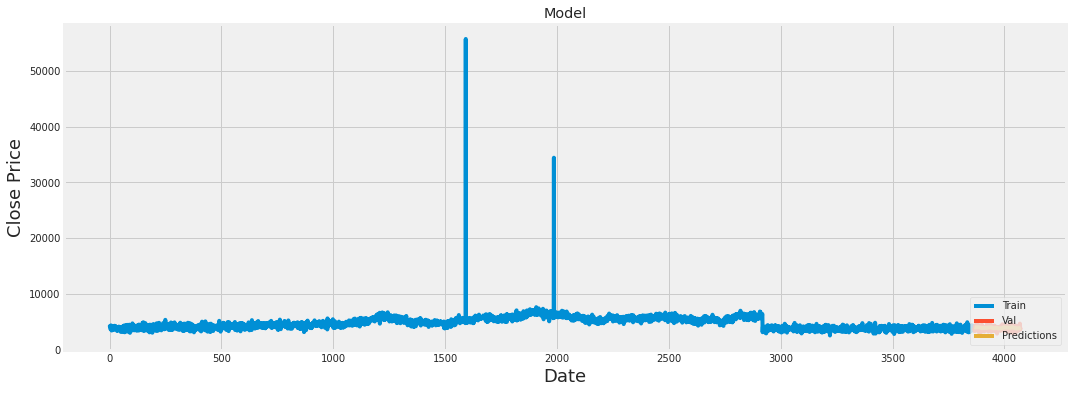

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Natural Gas Corp of Utopia
******************************************************************************************
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_34 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 50)            

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


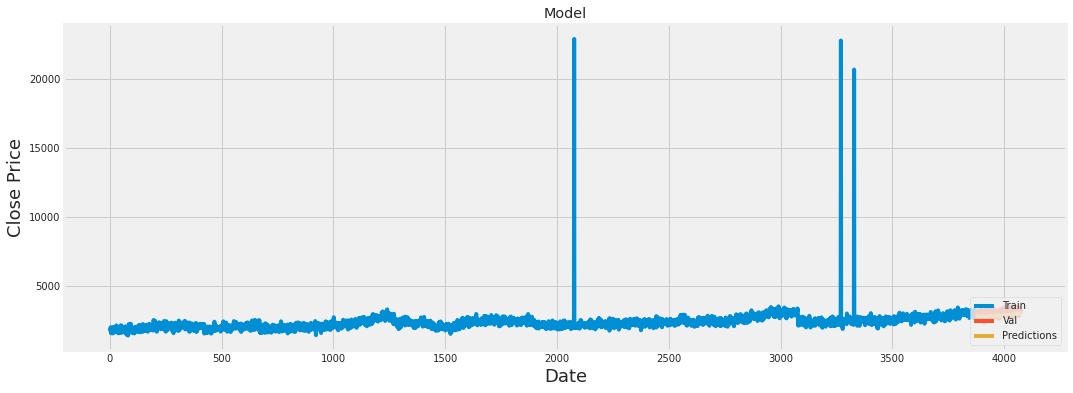

(1, 100)
i am at last
output saved into csv
******************************************************************************************
Company name Utopia Energy
******************************************************************************************
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_36 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_37 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 50)                20200    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


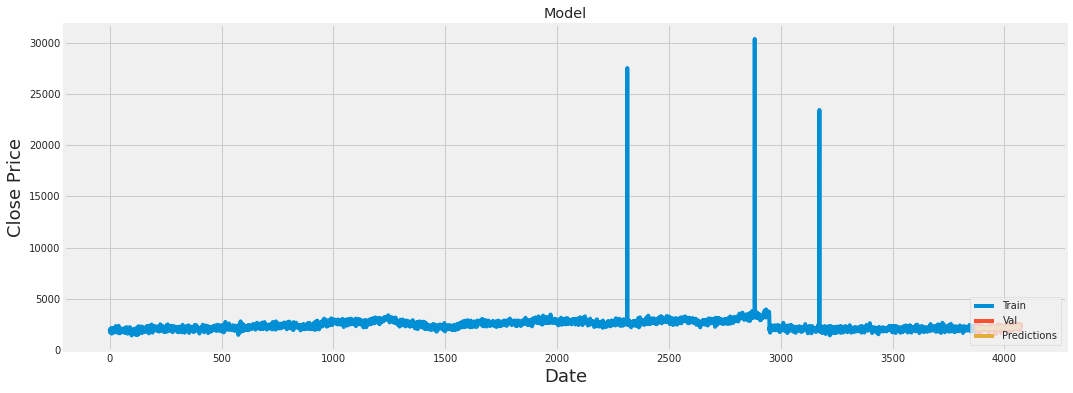

(1, 100)
i am at last
output saved into csv


In [19]:
for company in company_list:
# company='Utopia Petroleums'
    print('******************************************************************************************')
    print('Company name', company)
    print('******************************************************************************************')
    dataset,training_data_len, scaler, scaled_data, x_train, y_train=generate_train_test(company)
    model=LSTM_model(x_train)
    test_data, x_test, y_test= generate_test_set(dataset, scaler, scaled_data, training_data_len)

    # Train the model
    model.fit(x_train, y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64,verbose=1)
    predictions=predict_test_set(x_test, y_test, model)
    company_df= final_df[final_df['company_name']==company][['Close']]
    visualize_results(company_df, training_data_len, predictions)

    #predict for next 30 days
    x_input=test_data[(x_test.shape[0]):].reshape(1,-1)
    print(x_input.shape)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    # demonstrate prediction for next 30 days
    from numpy import array

    lst_output=[]
    n_steps=100
    i=0
    while(i<30):

        if(len(temp_input)>100):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
    #         print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
    #         print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
    #         print(yhat[0])
            temp_input.extend(yhat[0].tolist())
    #         print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1

    print('i am at last')
    out_df=pd.DataFrame((scaler.inverse_transform(lst_output)), columns=['output'])
    out_df.to_csv(company+'_prediction.csv')
    print('output saved into csv')